In [ ]:
# pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



In [2]:
# Load data
data = pd.read_csv('augmented_file_50x.csv')

In [ ]:
data['label'].value_counts()

In [ ]:
data.describe()

In [ ]:
# Visualizing the data distribution between temperature, ph and rainfall

plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.distplot(data['temperature'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['ph'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['rainfall'],color="green",bins=15,hist_kws={'alpha':0.2})


In [ ]:
# Visualizing the data distribution between N, P, and K

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
sns.distplot(data['N'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['P'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['K'],color="green",bins=15,hist_kws={'alpha':0.2})

In [3]:
# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Lists to collect split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split each label's data separately
labels = y.unique()
for label in labels:
    X_label = X[y == label]
    y_label = y[y == label]
    
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        X_label, y_label, test_size=0.20, random_state=0)
    
    X_train_list.append(X_train_label)
    X_test_list.append(X_test_label)
    y_train_list.append(y_train_label)
    y_test_list.append(y_test_label)

# Concatenate splits
X_train = pd.concat(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))



Training set size: 88000
Testing set size: 22000


Cross-validated accuracy scores for each fold: [0.95       0.94988636 0.94693182 0.95193182 0.95272727 0.94920455
 0.95056818 0.94647727 0.94840909 0.95056818]
Mean CV Accuracy: 0.9496704545454546
Standard Deviation of CV Accuracy: 0.001890227423021842
Calibrated Random Forest Validation accuracy: 0.985
Calibrated Random Forest Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       504
      banana       1.00      1.00      1.00       514
   blackgram       0.98      0.99      0.98       522
    chickpea       1.00      1.00      1.00       514
     coconut       1.00      0.96      0.98       499
      coffee       1.00      1.00      1.00       499
      cotton       1.00      1.00      1.00       496
      grapes       1.00      1.00      1.00       496
        jute       0.82      1.00      0.90       474
 kidneybeans       1.00      1.00      1.00       494
      lentil       0.99      0.96      0.97       53

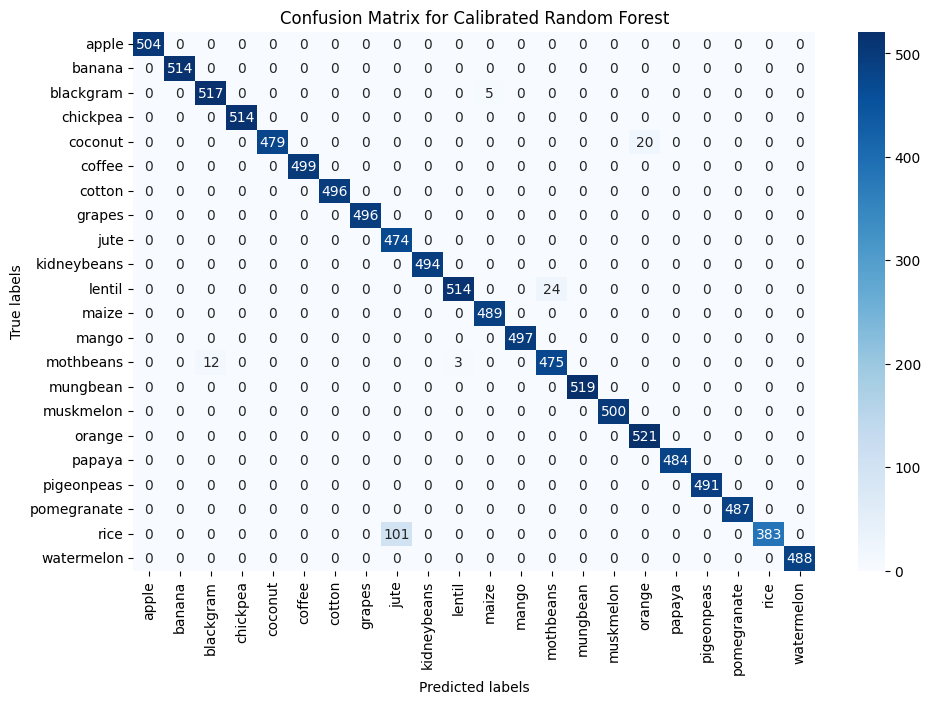

In [6]:

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_resampled, y_resampled = under.fit_resample(X_train, y_train)

# Train the Random Forest on the resampled data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=4, random_state=0)
clf_rf.fit(X_resampled, y_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores = cross_val_score(clf_rf, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Split the test set further into calibration and validation sets
X_calibrate, X_validate, y_calibrate, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Calibrate the classifier on the calibration set
calibrated_rf = CalibratedClassifierCV(clf_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_calibrate, y_calibrate)

# Predict on the validation set using the calibrated RF
y_pred_calibrated = calibrated_rf.predict(X_validate)
accuracy_score_rf = accuracy_score(y_validate, y_pred_calibrated)

print("Calibrated Random Forest Validation accuracy:", accuracy_score_rf)
print("Calibrated Random Forest Classification Report:")
print(classification_report(y_validate, y_pred_calibrated))

# Compute the confusion matrix for calibrated RF
conf_mat_calibrated = confusion_matrix(y_validate, y_pred_calibrated)
class_labels = np.unique(y_validate)

# Plot using Seaborn for calibrated RF
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_calibrated, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Calibrated Random Forest')
plt.show()





In [ ]:

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')

# Apply the undersampling strategy
X_train_resampled, y_train_resampled = under.fit_resample(X_train_scaled, y_train)

# Define the K-nearest neighbors (KNN) classifier with adjusted parameters
clf_knn = KNeighborsClassifier(n_neighbors=5001, weights='distance', algorithm='auto', p=2)

# Fit the KNN model with resampled training data
clf_knn.fit(X_train_resampled, y_train_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores_knn = cross_val_score(clf_knn, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold (KNN):", cv_scores_knn)
print("Mean CV Accuracy (KNN):", cv_scores_knn.mean())
print("Standard Deviation of CV Accuracy (KNN):", cv_scores_knn.std())

# Predict using the KNN model on the scaled test set
y_pred_knn = clf_knn.predict(X_test_scaled)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)

print("K-nearest Neighbors Test accuracy:", accuracy_score_knn)
print("K-nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Compute the confusion matrix
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_knn, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-nearest Neighbors')
plt.show()



In [ ]:

# Set up the RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Set var_smoothing parameter for regularization; you can adjust the value as needed
var_smoothing_value = 1e-1
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 10-fold cross-validation on undersampled data
cv_scores = cross_val_score(clf_nb, X_train_under, y_train_under, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the clf_nb with the undersampled training data and predict for the test set
clf_nb.fit(X_train_under, y_train_under)
y_pred_nb = clf_nb.predict(X_test)
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)

# Print the Naive Bayes Classification Report
print("Naive Bayes Test accuracy:", accuracy_score_nb)
print(classification_report(y_test, y_pred_nb))

# Compute the confusion matrix
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

# Extract unique class labels
class_labels = np.unique(y)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_nb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()



In [ ]:
# # Use pipeline to ensure that the data is scaled before applying SVM
# clf_svm = make_pipeline(
#     StandardScaler(), 
#     SVC(gamma = 0.1, C=0.01, random_state=0) # Updated kernel and gamma
# )

# # Using the pipeline to fit and predict ensures that scaling is applied in each step of CV and prediction.
# clf_svm.fit(X_train_temp, y_train_temp)

# # Perform 5-fold cross-validation
# cv_scores_svm = cross_val_score(clf_svm, X, y, cv=5, scoring='accuracy')

# # Print out the scores for each fold and average accuracy for SVM
# print("Cross-validated accuracy scores for each fold (SVM):", cv_scores_svm)
# print("Mean CV Accuracy (SVM):", cv_scores_svm.mean())
# print("Standard Deviation of CV Accuracy (SVM):", cv_scores_svm.std())

# y_pred_svm = clf_svm.predict(X_test)
# accuracy_score_svm = accuracy_score(y_test, y_pred_svm)

# print("SVM Test accuracy:", accuracy_score_svm)
# print("SVM Classification Report:")
# print(classification_report(y_test, y_pred_svm))


# # Compute the confusion matrix
# conf_mat_svm = confusion_matrix(y_test, y_pred_rf)

# # Extract unique class labels
# class_labels = data['label'].unique()

# # Plot using Seaborn
# plt.figure(figsize=(10,7))
# sns.heatmap(conf_mat_svm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix for SVM')
# plt.show()

# # # Compute macro-average ROC curve and ROC area for multi-class task for SVM
# # fpr_svm = dict()
# # tpr_svm = dict()
# # roc_auc_svm = dict()

# # for i in range(n_classes):
# #     fpr_svm[i], tpr_svm[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_svm[:, i])
# #     roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# # all_fpr_svm = np.unique(np.concatenate([fpr_svm[i] for i in range(n_classes)]))
# # mean_tpr_svm = np.zeros_like(all_fpr_svm)
# # for i in range(n_classes):
# #     mean_tpr_svm += np.interp(all_fpr_svm, fpr_svm[i], tpr_svm[i])
# # mean_tpr_svm /= n_classes

# # fpr_svm["macro"] = all_fpr_svm
# # tpr_svm["macro"] = mean_tpr_svm
# # roc_auc_svm["macro"] = auc(fpr_svm["macro"], tpr_svm["macro"])

# # print("SVM Macro-average of ROC curve:", roc_auc_svm["macro"])

# # # Plot the ROC curve for SVM
# # plt.figure()
# # plt.plot(fpr_svm["macro"], tpr_svm["macro"],
# #          label='macro-average ROC curve (area = {0:0.2f})'
# #                ''.format(roc_auc_svm["macro"]),
# #          color='green', linestyle=':', linewidth=4)
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('Receiver Operating Characteristic Curve for SVM')
# # plt.legend(loc="lower right")
# # plt.show()

In [ ]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Adjusted the dataset name here
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with stronger regularization (smaller C value)
clf_lr = LogisticRegression(C=0.001, max_iter=5000, random_state=0)  
clf_lr.fit(X_train_scaled, y_train)  # Adjusted the dataset names here

# Remember to scale the entire dataset for cross-validation
X_scaled = scaler.transform(X)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf_lr, X_scaled, y, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Test accuracy:", accuracy_score_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Compute the confusion matrix
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_lr, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')  # Updated the title here
plt.show()


In [ ]:

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_resampled, y_resampled = under.fit_resample(X_train, y_train)

# Define the XGBoost classifier
clf_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    random_state=0
)

param_dist = {
    'n_estimators': [5, 50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize RandomizedSearchCV with 10 fold cross-validation
random_search = RandomizedSearchCV(
    clf_xgb, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='accuracy', 
    cv=10, 
    verbose=1, 
    n_jobs=-1, 
    random_state=0
)

# Fit the random search model
random_search.fit(X_resampled, y_resampled)

# Predict on the test set using the best parameters found
y_pred_xgb = random_search.best_estimator_.predict(X_test)

# Output test accuracy and classification report
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)
cv_scores = random_search.cv_results_['mean_test_score']
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation of CV Accuracy:", np.std(cv_scores))
print("XGBoost Test accuracy:", accuracy_score_xgb)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Compute the confusion matrix
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)
class_labels = np.unique(y_test)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_xgb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()




In [7]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_score_rf)
# print("KNN:", accuracy_score_knn)
# print("Naive Bayes Accuracy:", accuracy_score_nb)
# # print("SVM Accuracy:", accuracy_score_svm)
# print("Logistic Regression Accuracy (Scaled Data):", accuracy_score_lr)
# print("XGBoost Accuracy:", accuracy_score_xgb)


Random Forest Accuracy: 0.985


In [ ]:
model_names = ['Random Forest', 'KNN', 'Naive Bayes', 'Logistic Regression', 'XGBoost'] # Add 'SVM'
accuracies = [accuracy_score_rf, accuracy_score_knn, accuracy_score_nb, accuracy_score_lr, accuracy_score_xgb] # Add ccuracy_score_svm

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Using consistent colors with a slight alpha transparency and edge color
bars = ax.bar(model_names, accuracies, color='skyblue', alpha=0.75, edgecolor='black')

# Adding data labels with 4 decimal places
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, "{:.5f}".format(yval), ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10)  # labelpad adds some padding to the ylabel
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.125)  # Added a bit more space at the top for the data labels
ax.set_yticks([i/10 for i in range(11)])
ax.set_yticklabels([i/10 for i in range(11)], fontsize=10)
ax.set_xticks(range(len(model_names)))

# Adjusting font size of the classifier names
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Reduced font size to 10

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)  # Adding horizontal grid lines

# Adjust the position of the axes to create margins inside the chart
ax.set_position([0.5, 0.5, 0.7, 0.7])  # left, bottom, width, height


plt.show()

**Making Predictions**

In [9]:
# Define the original feature names and input data
original_feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
data = np.array([[102, 28, 54, 25.15623099, 80.27525115, 6.862157042, 55.49541453]])
data_df = pd.DataFrame(data, columns=original_feature_names)

# List of classifiers
classifiers = {
    "Random Forest": clf_rf,
    # "KNN": clf_knn,
    # "Naive Bayes": clf_nb,
    # "Logistic Regression": clf_lr,
    # "XGBoost": clf_xgb,
}

# Predict using each classifier and print the prediction
for clf_name, clf in classifiers.items():
    proba = clf.predict_proba(data_df.values)
    predicted_index = np.argmax(proba)  # index of max probability
    
    if clf_name == "XGBoost":
        predicted_label = le.inverse_transform([predicted_index])[0]
    else:
        # Assuming your classifiers have classes_ attribute to get label names
        predicted_label = clf.classes_[predicted_index]
    
    confidence = proba[0][predicted_index] * 100  # Fetching the probability of the predicted class
    
    print(f"{clf_name} prediction: {predicted_label} with {confidence:.4f}% confidence")




Random Forest prediction: watermelon with 50.6904% confidence
